In [2]:
import pandas as pd 
import numpy as np 
import cv2 # Used to manipulated the images 
np.random.seed(1337) # The seed I used - pick your own or comment out for a random seed. A constant seed allows for better comparisons though

# Import Keras 
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Activation
from keras.layers import Conv2D, MaxPooling2D
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras.layers.normalization import BatchNormalization
from keras.optimizers import Adam
from sklearn.model_selection import train_test_split

Using TensorFlow backend.


In [5]:
#Load data
df_train = pd.read_json("C:/Users/Aymar/machine-learning/projects/capstone/C-Foil/data/processed/train.json")
df_test = pd.read_json("C:/Users/Aymar/machine-learning/projects/capstone/C-Foil/data/processed/test.json")
print ("done!")

done!


In [6]:
# Train data
# Need to reshape and feature scale the images:

def get_scaled_imgs(df):
    imgs = []
    
    for i, row in df.iterrows():
        #make 75x75 image
        x_band1 = np.array(row['band_1']).reshape(75, 75)
        x_band2 = np.array(row['band_2']).reshape(75, 75)
        x_band3 = x_band1 + x_band2 # plus since log(x*y) = log(x) + log(y)
        
        # Rescale
        a = (x_band1 - x_band1.mean()) / (x_band1.max() - x_band1.min())
        b = (x_band2 - x_band2.mean()) / (x_band2.max() - x_band2.min())
        c = (x_band3 - x_band3.mean()) / (x_band3.max() - x_band3.min())

        imgs.append(np.dstack((a, b, c)))

    return np.array(imgs)


In [7]:
X_train = get_scaled_imgs(df_train)

In [8]:
#Looks like we have 1604 images where whether or not the image contains an iceberg is labeled. The only features 
#are the HH and HV bands, the image id, incidence angle (note: has missing values ... 
#that is why it shows up as an object instead of a numeric), and whether or not there is an iceberg.

df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1604 entries, 0 to 1603
Data columns (total 5 columns):
band_1        1604 non-null object
band_2        1604 non-null object
id            1604 non-null object
inc_angle     1604 non-null object
is_iceberg    1604 non-null int64
dtypes: int64(1), object(4)
memory usage: 62.7+ KB


In [9]:
#Five times as many test images! With this ratio, it would no doubt be helpful to do some unsupervised clustering 
#on the test dataset to improve our model. I will add that to the to do list.
#No lat/lon information, time of year, etc. that might have proved useful. All the features to engineer will have 
#to come from those radar echos.
#Thanks to MuonNeutrino, an excellent starting point is investigating the statistical properties of the two separate 
#bands.

df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8424 entries, 0 to 8423
Data columns (total 4 columns):
band_1       8424 non-null object
band_2       8424 non-null object
id           8424 non-null object
inc_angle    8424 non-null float64
dtypes: float64(1), object(3)
memory usage: 263.3+ KB


In [10]:
# coerce incidence angle to numeric
df_train['inc_angle'] = pd.to_numeric(df_train['inc_angle'], errors='coerce')

# combine training and test set for feature engineering
df_full = pd.concat([df_train, df_test], axis=0, ignore_index=True)

In [11]:
#Looks like the minimum, maximum, median, and mean reflectivities are useful features ... 
#particularly the maximum reflectivity! This makes intuitive sense. The icebergs are scattering back more 
#information to the radar. Also the first and third quartile features are useful.
#Now let's look at the second band.
import matplotlib as 

def get_stats(df, label=1):
    df['max'+str(label)] = [np.max(np.array(x)) for x in df['band_'+str(label)] ]
    df['maxpos'+str(label)] = [np.argmax(np.array(x)) for x in df['band_'+str(label)] ]
    df['min'+str(label)] = [np.min(np.array(x)) for x in df['band_'+str(label)] ]
    df['minpos'+str(label)] = [np.argmin(np.array(x)) for x in df['band_'+str(label)] ]
    df['med'+str(label)] = [np.median(np.array(x)) for x in df['band_'+str(label)] ]
    df['std'+str(label)] = [np.std(np.array(x)) for x in df['band_'+str(label)] ]
    df['mean'+str(label)] = [np.mean(np.array(x)) for x in df['band_'+str(label)] ]
    df['p25_'+str(label)] = [np.sort(np.array(x))[int(0.25*75*75)] for x in df['band_'+str(label)] ]
    df['p75_'+str(label)] = [np.sort(np.array(x))[int(0.75*75*75)] for x in df['band_'+str(label)] ]
    df['mid50_'+str(label)] = df['p75_'+str(label)]-df['p25_'+str(label)]

    return df

df_full = get_stats(df_full, 1)
df_full = get_stats(df_full, 2)

In [20]:
def plot_var(name,nbins=50):
    minval = df_train[name].min()
    maxval = df_train[name].max()
    plt.hist(df_train.loc[df_train.is_iceberg==1,name],range=[minval,maxval],
             bins=nbins,color='b',alpha=0.5,label='Boat')
    plt.hist(df_train.loc[df_train.is_iceberg==0,name],range=[minval,maxval],
             bins=nbins,color='r',alpha=0.5,label='Iceberg')
    plt.legend()
    plt.xlim([minval,maxval])
    plt.xlabel(name)
    plt.ylabel('Number')
    plt.show()

C:\Users\Aymar\Anaconda2\envs\aind-dl\lib\site-packages\numpy\lib\function_base.py:583: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= mn)
C:\Users\Aymar\Anaconda2\envs\aind-dl\lib\site-packages\numpy\lib\function_base.py:584: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= mx)


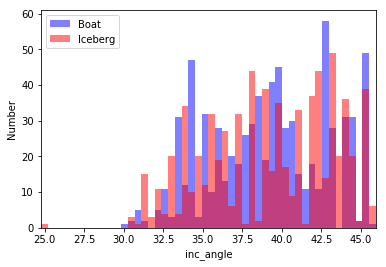

KeyError: 'min1'

In [22]:
#Interesting. The minimum reflectivity doesn't appear useful at all for band_2. 
#However, the maximum reflectivity is! Additionally, we can almost guarantee that if the standard deviation 
#of the values is over 3 then the image contains an iceberg.
#So far, it seems that the features most usefull are:
#    min1, max1, std1, med1, mean1, p25_1, p75_1 (from band_1)
#    max2, std2 (from band_2)
#Now let's look at the correlation between these features:
import matplotlib.pyplot as plt

for col in ['inc_angle','min1','max1','std1','med1','mean1','mid50_1']:
    plot_var(col)

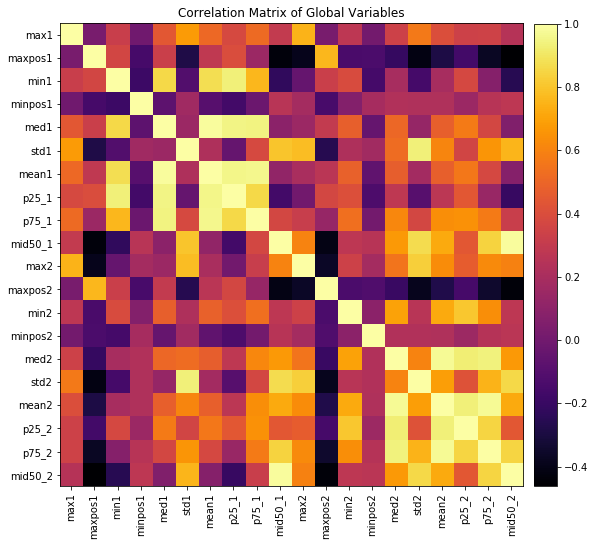

In [24]:
#Unfortunately max1 and max2 are pretty highly correlated, so we might not get much additional information 
#including both in there. The minimums aren't too correlated with the maximums in both bands, however, 
#so each might be useful.
#Going back to the value of the maximum reflectivity, let's see if the number of pixels above some 
#threshold could be useful.

df_full_stats = df_full.drop(['id','is_iceberg','band_1','band_2', 'inc_angle'], axis=1)
corr = df_full_stats.corr()
fig = plt.figure(1, figsize=(10,10))
plt.imshow(corr,cmap='inferno')
labels = np.arange(len(df_full_stats.columns))
plt.xticks(labels,df_full_stats.columns,rotation=90)
plt.yticks(labels,df_full_stats.columns)
plt.title('Correlation Matrix of Global Variables')
cbar = plt.colorbar(shrink=0.85,pad=0.02)
plt.show()

In [ ]:
#Evaluation of different engineered features and their importance when making a prediction.
#inc_angle is the most important feature, but it does not appear to be sufficient on its own. When training, 
#I did not exclude missing values angles which are never icebergs, which would make it appear to be a more important 
#feature.
#Max and variance are also very important features. "Size" (at least as calculated) does not appear to be significant. 
#Possibly some additional refinement of that formula (coordinates greater than the mean + 1 standard deviation) would 
#be helpful.

C:\Users\Aymar\Anaconda2\envs\aind-dl\lib\site-packages\numpy\lib\function_base.py:583: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= mn)
C:\Users\Aymar\Anaconda2\envs\aind-dl\lib\site-packages\numpy\lib\function_base.py:584: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= mx)


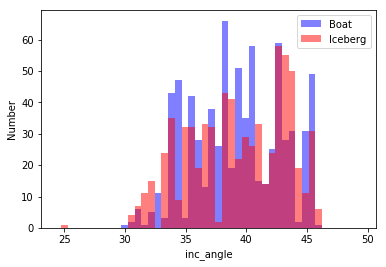

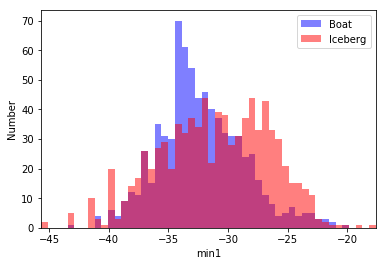

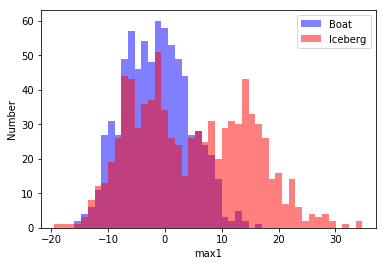

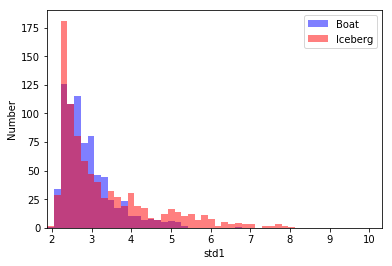

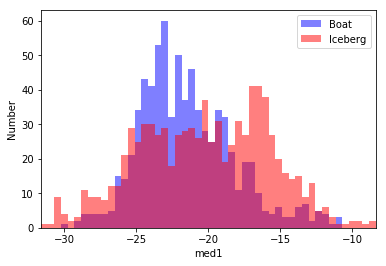

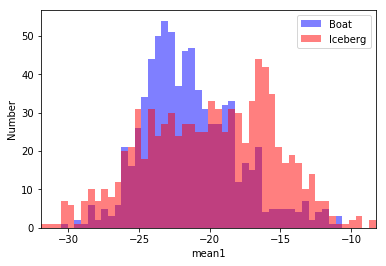

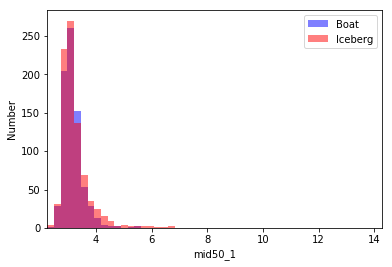

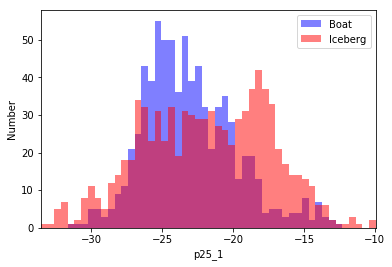

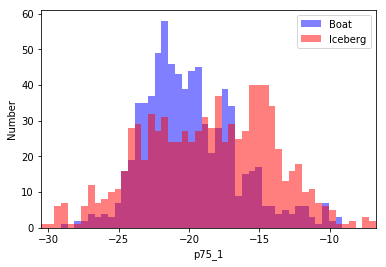

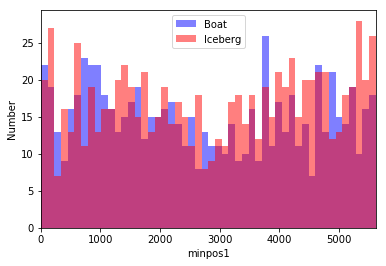

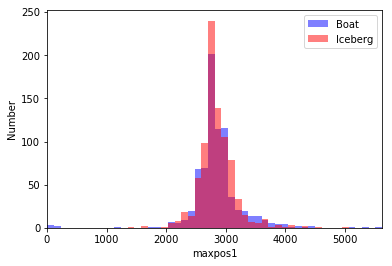

In [25]:
import matplotlib.pyplot as plt

def plot_var(name, nbins=50):
    minval = df_full[name].min()
    maxval = df_full[name].max()
    plt.hist(df_full.loc[df_full.is_iceberg==1,name],range=[minval,maxval],
             bins=nbins,color='b',alpha=0.5,label='Boat')
    plt.hist(df_full.loc[df_full.is_iceberg==0,name],range=[minval,maxval],
             bins=nbins,color='r',alpha=0.5,label='Iceberg')
    plt.legend()
    plt.xlim([minval, maxval])
    plt.xlabel(name)
    plt.ylabel('Number')
    plt.show()
    
for col in ['inc_angle','min1','max1','std1','med1','mean1','mid50_1', 'p25_1', 'p75_1', 'minpos1', 'maxpos1']:
    plot_var(col)

In [26]:
icebergs = df_train[df_train.is_iceberg==1].sample(n=9,random_state=123)
ships = df_train[df_train.is_iceberg==0].sample(n=9,random_state=456)

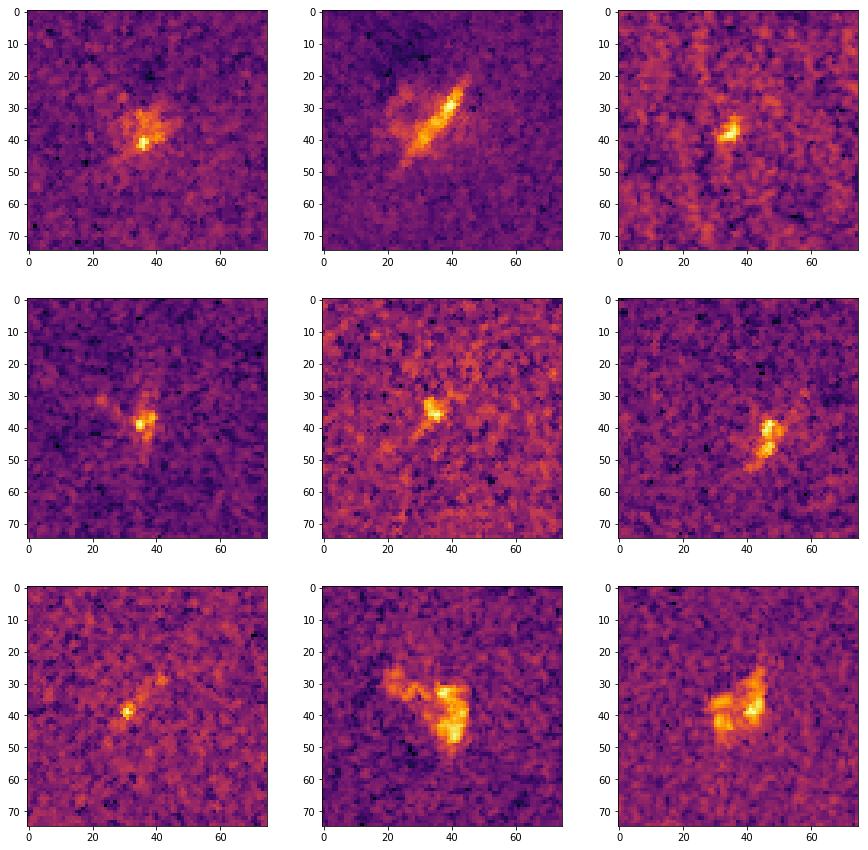

In [27]:
# Plot band_1
fig = plt.figure(1,figsize=(15,15))
for i in range(9):
    ax = fig.add_subplot(3,3,i+1)
    arr = np.reshape(np.array(icebergs.iloc[i,0]),(75,75))
    ax.imshow(arr,cmap='inferno')
    
plt.show()

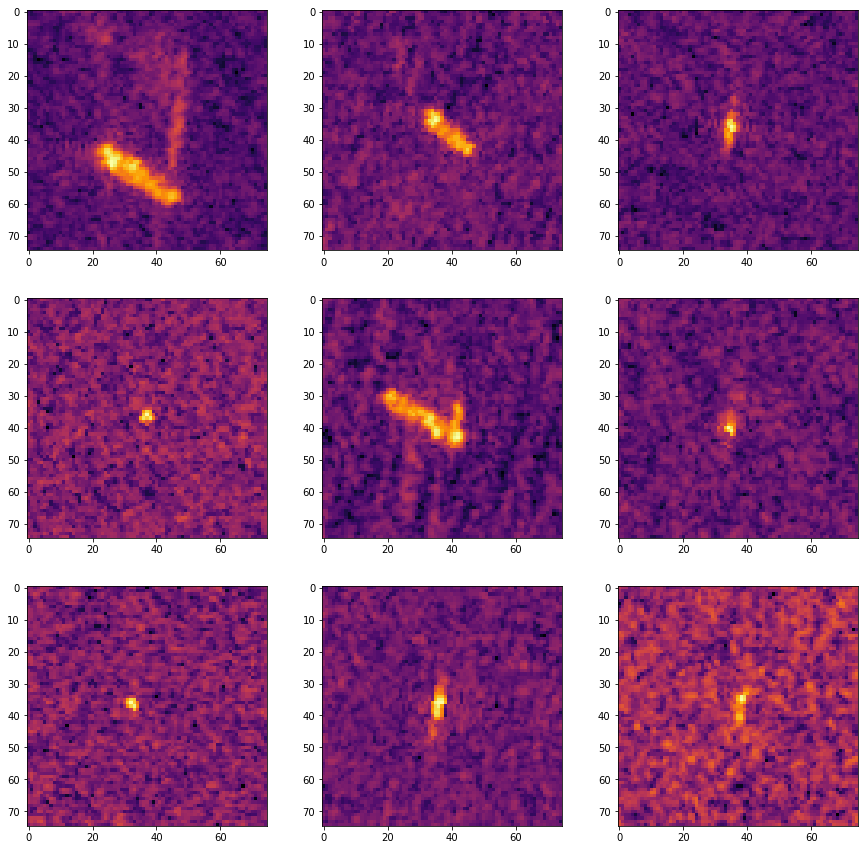

In [28]:
# Plot band_1
fig = plt.figure(1,figsize=(15,15))
for i in range(9):
    ax = fig.add_subplot(3,3,i+1)
    arr = np.reshape(np.array(ships.iloc[i,0]),(75,75))
    ax.imshow(arr,cmap='inferno')
    
plt.show()

In [15]:
# Get the response variable "is_iceberg"
y_train = np.array(df_train['is_iceberg'])

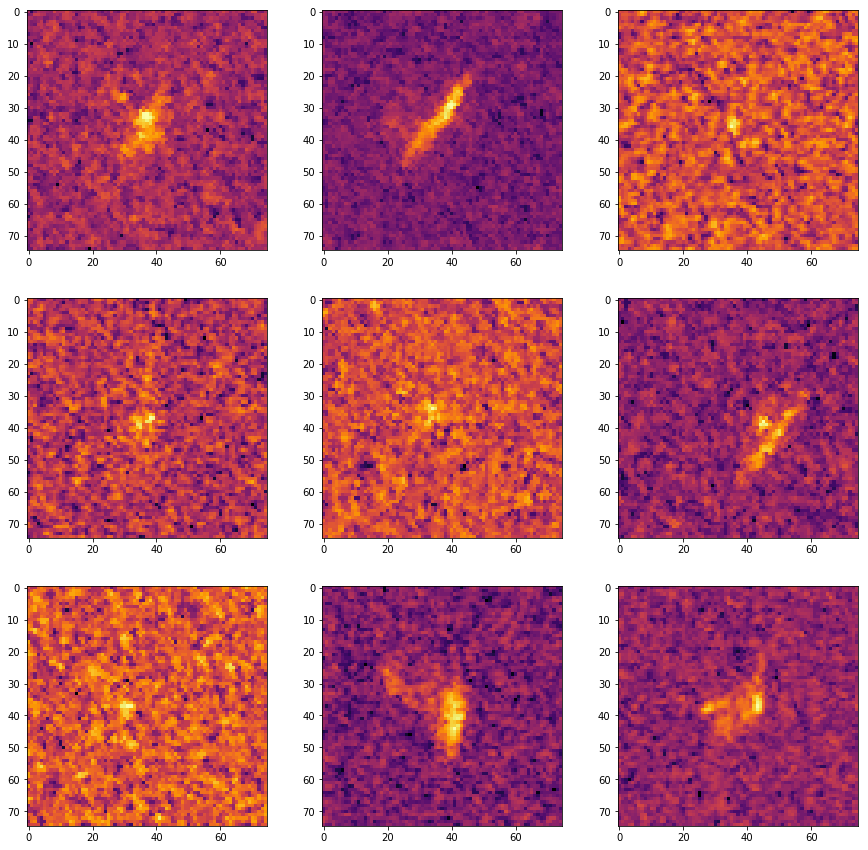

In [30]:
# Iceberg - Plot band_1
fig = plt.figure(1,figsize=(15,15))
for i in range(9):
    ax = fig.add_subplot(3,3,i+1)
    arr = np.reshape(np.array(icebergs.iloc[i,1]),(75,75))
    ax.imshow(arr,cmap='inferno')
    
plt.show()

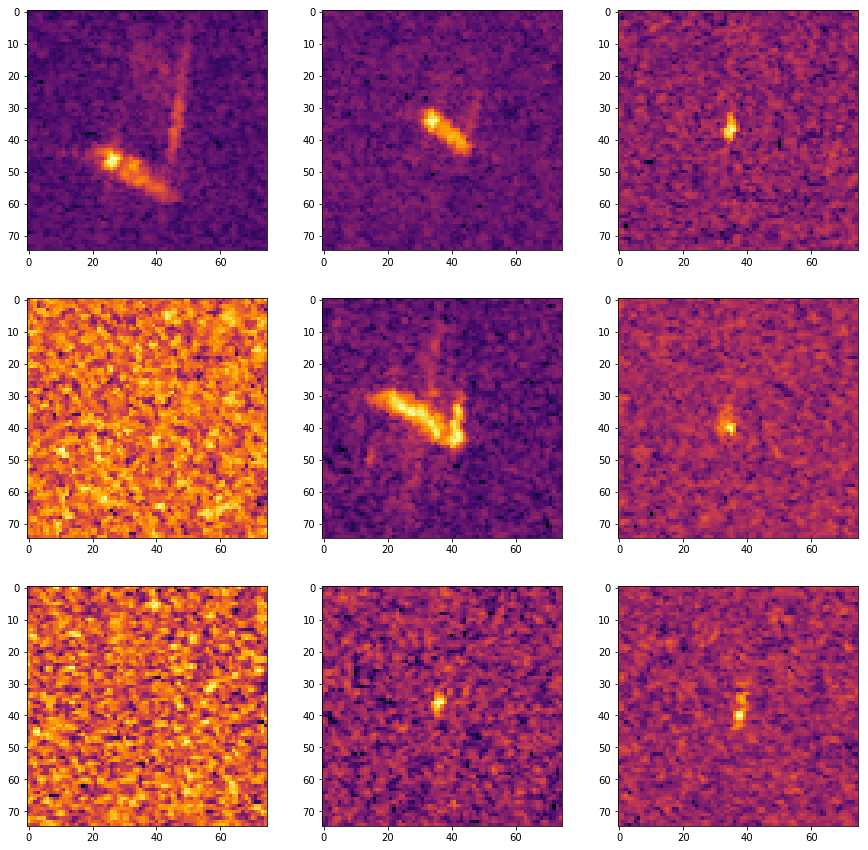

In [31]:
# Iceberg - Plot band_1
fig = plt.figure(1,figsize=(15,15))
for i in range(9):
    ax = fig.add_subplot(3,3,i+1)
    arr = np.reshape(np.array(ships.iloc[i,1]),(75,75))
    ax.imshow(arr,cmap='inferno')
    
plt.show()

In [32]:
from scipy import signal

xder = np.array([[-1,0,1],[-2,0,2],[-1,0,1]])
yder = np.array([[1,2,1],[0,0,0],[-1,-2,-1]])
smooth = np.array([[1,1,1],[1,5,1],[1,1,1]])
xder2 = np.array([[-1,2,-1],[-3,6,-3],[-1,2,-1]])
yder2 = np.array([[-1,-3,-1],[2,6,2],[-1,-3,-1]])

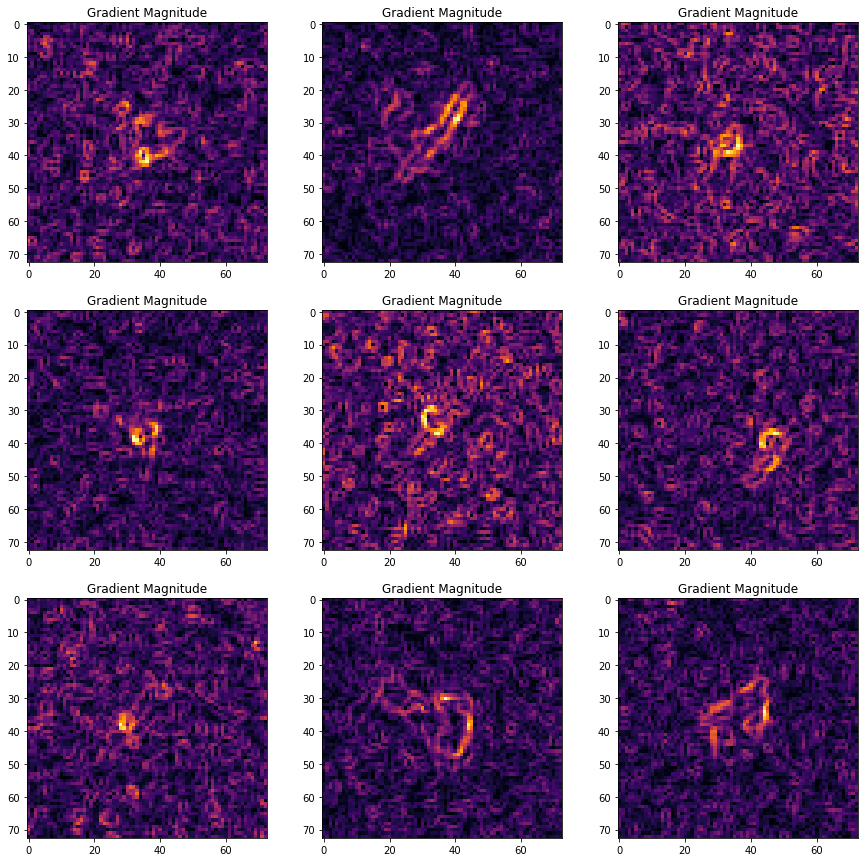

In [33]:
# Plot band_1
fig = plt.figure(1,figsize=(15,15))
for i in range(9):
    ax = fig.add_subplot(3,3,i+1)
    arrx = signal.convolve2d(np.reshape(np.array(icebergs.iloc[i,0]),(75,75)),xder,mode='valid')
    arry = signal.convolve2d(np.reshape(np.array(icebergs.iloc[i,0]),(75,75)),yder,mode='valid')
    ax.imshow(np.hypot(arrx,arry),cmap='inferno')
    ax.set_title('Gradient Magnitude')
    
plt.show()

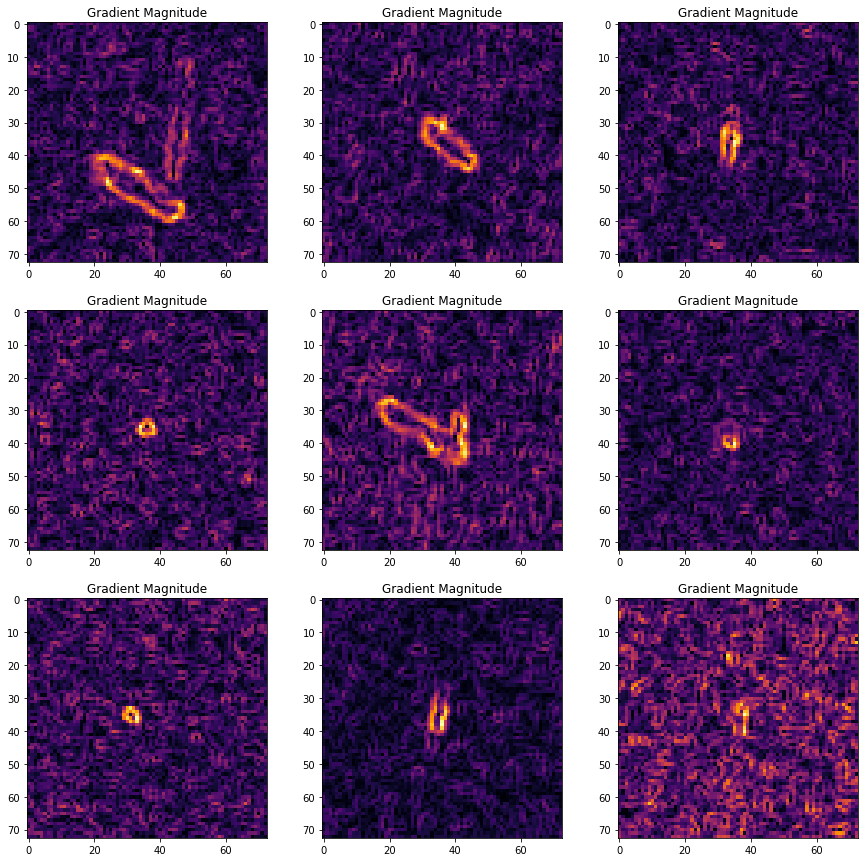

In [34]:
# Plot band_1
fig = plt.figure(1,figsize=(15,15))
for i in range(9):
    ax = fig.add_subplot(3,3,i+1)
    arrx = signal.convolve2d(np.reshape(np.array(ships.iloc[i,0]),(75,75)),xder,mode='valid')
    arry = signal.convolve2d(np.reshape(np.array(ships.iloc[i,0]),(75,75)),yder,mode='valid')
    ax.imshow(np.hypot(arrx,arry),cmap='inferno')
    ax.set_title('Gradient Magnitude')
    
plt.show()

In [15]:
# Some of the incident angle from the satellite are unknown and marked as "na". Replace these na with 0 and find 
# the indices where the incident angle is >0 (this way you can use a truncated set or the full set of training data).

df_train.inc_angle = df_train.inc_angle.replace('na',0)
idx_tr = np.where(df_train.inc_angle > 0)

In [16]:
# You can now use the option of training with only known incident angles or the whole set. 
# I found slightly better results training with only the known incident angles so:

ytrain = y_train[idx_tr[0]]
Xtrain = X_train[idx_tr[0],...]

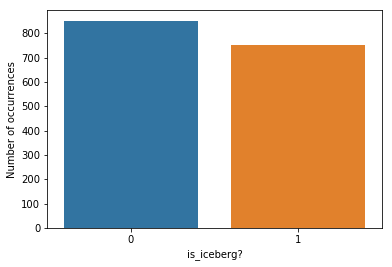

In [35]:
import matplotlib.pyplot as plt
import seaborn as sns

### Target variable exploration
sns.countplot(y_train);
plt.xlabel('is_iceberg?');
plt.ylabel('Number of occurrences');
plt.show()

In [16]:
df_train['is_iceberg'].value_counts()

0    851
1    753
Name: is_iceberg, dtype: int64

In [17]:
# Now, the biggest improvement I had was by adding more data to train on. I did this by simply including 
# horizontally and vertically flipped data. Using OpenCV this is easily done.

def get_more_images(imgs):
    
    more_images = []
    vert_flip_imgs = []
    hori_flip_imgs = []
      
    for i in range(0,imgs.shape[0]):
        a=imgs[i,:,:,0]
        b=imgs[i,:,:,1]
        c=imgs[i,:,:,2]
        
        av=cv2.flip(a,1)
        ah=cv2.flip(a,0)
        bv=cv2.flip(b,1)
        bh=cv2.flip(b,0)
        cv=cv2.flip(c,1)
        ch=cv2.flip(c,0)
        
        vert_flip_imgs.append(np.dstack((av, bv, cv)))
        hori_flip_imgs.append(np.dstack((ah, bh, ch)))
      
    v = np.array(vert_flip_imgs)
    h = np.array(hori_flip_imgs)
       
    more_images = np.concatenate((imgs,v,h))
    
    return more_images

In [18]:
X_train_new = get_more_images(Xtrain) 
y_train_new = np.concatenate((ytrain,ytrain,ytrain))

In [19]:
X_train1, X_valid, y_train1, y_valid = train_test_split(X_train_new
                    ,y_train_new, random_state=123, train_size=0.75)

In [20]:

#Build keras model

model=Sequential()

model.add(Conv2D(64, kernel_size=(3, 3),activation='relu', input_shape=(75, 75, 3)))
model.add(MaxPooling2D(pool_size=(3, 3), strides=(2, 2)))
model.add(Dropout(0.3))

model.add(Conv2D(128, kernel_size=(3, 3), activation='relu' ))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
model.add(Dropout(0.3))

model.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
model.add(Dropout(0.3))

model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
model.add(Dropout(0.3))

# You must flatten the data for the dense layers
model.add(Flatten())

#Dense 1
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.3))

#Dense 2
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.4))

# Output 
model.add(Dense(1, activation="sigmoid"))

In [22]:
#creating f1-score

import keras.backend as K

def f1_score(y_true, y_pred):

    # Count positive samples.
    c1 = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    c2 = K.sum(K.round(K.clip(y_pred, 0, 1)))
    c3 = K.sum(K.round(K.clip(y_true, 0, 1)))

    # If there are no true samples, fix the F1 score at 0.
    if c3 == 0:
        return 0

    # How many selected items are relevant?
    precision = c1 / c2

    # How many relevant items are selected?
    recall = c1 / c3

    # Calculate f1_score
    f1_score = 2 * (precision * recall) / (precision + recall)
    return f1_score

In [23]:
from keras import optimizers

optimizer = Adam(lr=0.001, decay=0.0)
model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy', f1_score])

In [24]:
model.summary()

batch_size = 32
earlyStopping = EarlyStopping(monitor='val_loss', patience=10, verbose=0, mode='min')
mcp_save = ModelCheckpoint('saved_models/weights.best.from_scratch.hdf5', verbose=1, save_best_only=True, monitor='val_loss', mode='min')
reduce_lr_loss = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=7, verbose=1, epsilon=1e-4, mode='min')

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 73, 73, 64)        1792      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 36, 36, 64)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 34, 34, 128)       73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 17, 17, 128)       0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 17, 17, 128)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 15, 15, 128)       147584    
__________

In [25]:

model.fit(X_train1, y_train1, 
          validation_data =(X_valid, y_valid), batch_size = batch_size, epochs = 50, verbose=1, 
          callbacks=[earlyStopping, mcp_save, reduce_lr_loss])

Train on 3309 samples, validate on 1104 samples
Epoch 1/50
3309/3309 [==============================] - 150s - loss: 0.6271 - acc: 0.6358 - f1_score: nan - val_loss: 0.5203 - val_acc: 0.7283 - val_f1_score: 0.7843
Epoch 2/50
3309/3309 [==============================] - 121s - loss: 0.4299 - acc: 0.8096 - f1_score: 0.8246 - val_loss: 0.3285 - val_acc: 0.8524 - val_f1_score: 0.8542
Epoch 3/50
3309/3309 [==============================] - 126s - loss: 0.3515 - acc: 0.8432 - f1_score: 0.8490 - val_loss: 0.3742 - val_acc: 0.8261 - val_f1_score: 0.8439
Epoch 4/50
3309/3309 [==============================] - 128s - loss: 0.3048 - acc: 0.8595 - f1_score: 0.8629 - val_loss: 0.2910 - val_acc: 0.8859 - val_f1_score: 0.8720
Epoch 5/50
3309/3309 [==============================] - 125s - loss: 0.2861 - acc: 0.8734 - f1_score: 0.8744 - val_loss: 0.2660 - val_acc: 0.8940 - val_f1_score: 0.8955
Epoch 6/50
3309/3309 [==============================] - 127s - loss: 0.2486 - acc: 0.8985 - f1_score: 0.8979 -

In [29]:
model.load_weights(filepath = 'saved_models/weights.best.from_scratch.hdf5')

score = model.evaluate(X_train1, y_train1, verbose=1, batch_size=200)
print('Train score:', score[0])
print('Train accuracy:', score[1])

3309/3309 [==============================] - 32s     
Train score: 0.0497611555026
Train accuracy: 0.986098529367


In [34]:
model.load_weights('saved_models/weights.best.from_scratch.hdf5')

score = model.evaluate(X_valid, y_valid, verbose=1, batch_size=200)
print('Test loss:', score[0])
print('Test fscore:', score[2])

1104/1104 [==============================] - 10s    
Test loss: 0.185285155
Test fscore: 0.93938435247


In [31]:
df_test.inc_angle = df_test.inc_angle.replace('na',0)
Xtest = (get_scaled_imgs(df_test))
pred_test = model.predict(Xtest)

submission = pd.DataFrame({'id': df_test["id"], 'is_iceberg': pred_test.reshape((pred_test.shape[0]))})
print(submission.head(10))

#submission.to_csv('submission.csv', index=False)

         id    is_iceberg
0  5941774d  6.127902e-04
1  4023181e  9.794163e-01
2  b20200e4  3.672249e-04
3  e7f018bb  9.999982e-01
4  4371c8c3  9.997824e-01
5  a8d9b1fd  1.899288e-02
6  29e7727e  1.989131e-02
7  92a51ffb  9.999996e-01
8  c769ac97  4.325067e-08
9  aee0547d  2.432615e-09


In [32]:
#Submission for each day.
submission = pd.DataFrame()
submission['id']=df_test['id']
submission['is_iceberg']=pred_test
submission.to_csv('C:/Users/Aymar/Desktop/Kaggle_compet/sub_1.csv', index=False)

In [ ]:
https://stackoverflow.com/questions/43345909/when-using-mectrics-in-model-compile-in-keras-report-valueerror-unknown-metr
    